In [1]:
from pathlib import Path
import os

import fsspec
import numpy as np
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dask.distributed import Client

import echopype as ep

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [2]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count())
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


In [39]:
# Setup filesystem
fs = fsspec.filesystem('s3', anon=True)
bucket = "ncei-wcsd-archive"
rawdirpath = "data/raw/Bell_M._Shimada/SH1707/EK60"

# Select the first 5 files from 2017 Hake Survey Cruise
s3rawfiles = fs.glob(f"{bucket}/{rawdirpath}/*.raw")
select_files = [
    s3path for s3path in s3rawfiles 
    if any([f"D2017{datestr}" in s3path for datestr in ['0728', '0729']])
]
print(f"There are {len(select_files)} target raw files available")

There are 170 target raw files available


In [3]:
base_dpath = Path('./exports/hake_cruise_tracks')
base_dpath.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = Path(base_dpath / 'hake_survey_echodata_zarr')
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = Path(base_dpath / 'combined_zarr')
combined_zarr_path.mkdir(exist_ok=True)

In [41]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in select_files:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:216: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:216: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/duck_array_ops.py:216: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


CPU times: user 24.6 s, sys: 2.95 s, total: 27.5 s
Wall time: 1min 34s


In [42]:
%%time

# Open Zarr Stores containing Echodata Objects, Lazy Load them, and Combine Echodata Objects
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

CPU times: user 2min 34s, sys: 9.26 s, total: 2min 43s
Wall time: 3min 33s


In [43]:
ed_combined

<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

In [45]:
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/xarray/core/dataset.py:2548: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(  # type: ignore[call-overload,misc]
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [4]:
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

In [5]:
%%time
# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(
    ed_combined,
    use_swap=True,
    chunk_dict={"ping_time": 1000}
)

CPU times: user 14 s, sys: 1.2 s, total: 15.2 s
Wall time: 33.1 s


In [6]:
# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, 9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

In [7]:
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

In [8]:
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

In [9]:
%%time
# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='5m',  # in meters
    ping_time_bin='20s',  # in seconds
)

CPU times: user 14.9 s, sys: 1.87 s, total: 16.8 s
Wall time: 1min 25s


In [10]:
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

In [4]:
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

In [5]:
# Compute Frequency Differencing 16.2dB >= 120kHz - 38kHz >= 10.0dB
# to capture Zooplankton
freq_diff_mask_1 = ep.mask.frequency_differencing(
    ds_MVBS,
    freqABEq="120000.0Hz - 38000.0Hz < 16.2dB"
)
freq_diff_mask_2 = ep.mask.frequency_differencing(
    ds_MVBS,
    freqABEq="120000.0Hz - 38000.0Hz > 10.0dB"
)

In [6]:
ds_freq_diff_MVBS = ep.mask.apply_mask(
    ds_MVBS,
    [freq_diff_mask_1, freq_diff_mask_2]
)

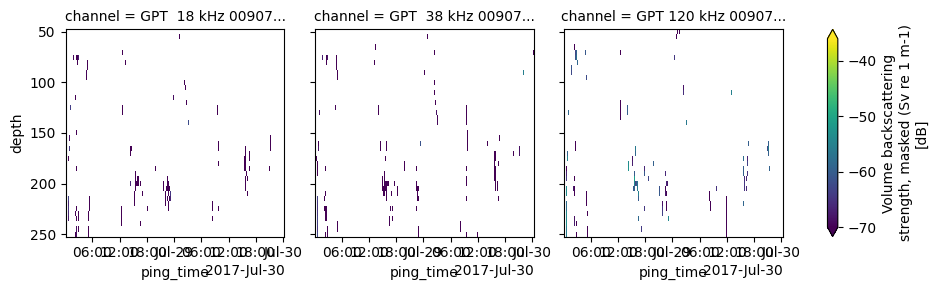

In [8]:
ds_freq_diff_MVBS["Sv"].sel(depth=slice(50, 250)).plot(col="channel", y="depth", yincrease=False, vmin=-70.0, vmax=-36)

In [9]:
ds_freq_diff_MVBS

<xarray.Dataset> Size: 32MB
Dimensions:            (channel: 3, ping_time: 8678, depth: 152)
Coordinates:
  * channel            (channel) <U37 444B 'GPT  18 kHz 009072058c8d 1-1 ES18...
  * depth              (depth) float64 1kB 0.0 5.0 10.0 ... 745.0 750.0 755.0
  * ping_time          (ping_time) datetime64[ns] 69kB 2017-07-28T00:05:20 .....
Data variables:
    Sv                 (channel, ping_time, depth) float64 32MB dask.array<chunksize=(3, 8678, 152), meta=np.ndarray>
    frequency_nominal  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    latitude           (ping_time) float64 69kB dask.array<chunksize=(8678,), meta=np.ndarray>
    longitude          (ping_time) float64 69kB dask.array<chunksize=(8678,), meta=np.ndarray>
Attributes:
    processing_function:          commongrid.compute_MVBS
    processing_level:             Level 3A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    processing_software_name:     echopype
    processing_software_version:  0.8.2.dev111+g46b62965
    processing_time:              2024-06-21T22:52:02Z
    mask_software_name:           echopype
    mask_software_version:        0.8.2.dev111+g46b62965
    mask_time:                    2024-06-21T22:54:32Z
    mask_function:                mask.apply_mask

In [10]:
gps_df = ds_freq_diff_MVBS.latitude.to_dataframe().join(ds_freq_diff_MVBS.longitude.to_dataframe())

gps_df.head(3)

,latitude,longitude
ping_time,,
2017-07-28 00:05:20,43.533086,-124.684009
2017-07-28 00:05:40,43.533187,-124.684080
2017-07-28 00:06:00,43.533353,-124.684202


In [11]:
gps_gdf = gpd.GeoDataFrame(
    gps_df,
    geometry=gpd.points_from_xy(gps_df['longitude'], gps_df['latitude']), 
    crs="epsg:4326"
)

<Axes: >

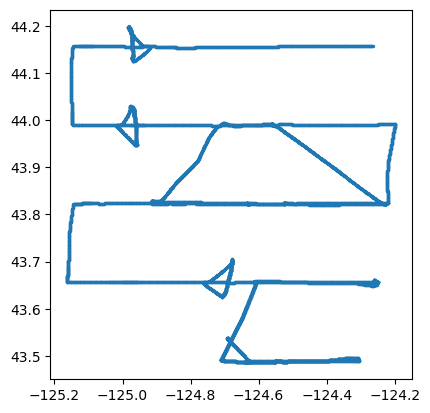

In [12]:
gps_gdf.plot(markersize=2)

In [13]:
tracksouth_bbox = gpd.GeoSeries(box(-125.17, 43.65, -125.14, 43.84), crs=gps_gdf.crs)
tracknorth_bbox = gpd.GeoSeries(box(-125.17, 43.98, -125.14, 44.17), crs=gps_gdf.crs)

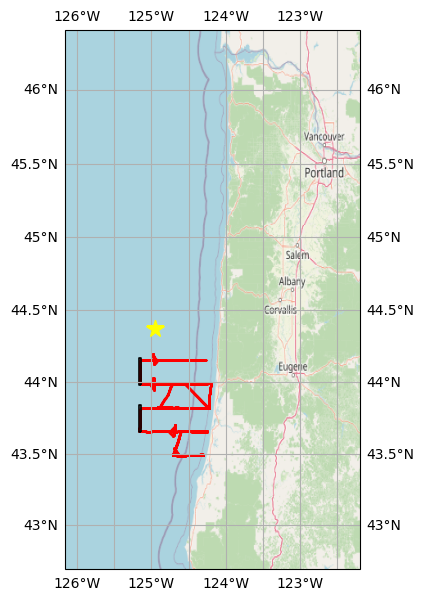

In [28]:
basemap = cimgt.OSM()

_, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": basemap.crs}
)
bnd = gps_gdf.geometry.bounds
ax.set_extent([bnd.minx.min() - 1, bnd.maxx.max() + 2, 
               bnd.miny.min() - 0.8, bnd.maxy.max() + 2.2])
ax.add_image(basemap, 7)
ax.gridlines(draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)

# GPS points
gps_gdf.plot(ax=ax, markersize=0.1, color='red', 
             transform=ccrs.PlateCarree())

# Bounding box for selected tracks
tracksouth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', 
                     transform=ccrs.PlateCarree())
tracknorth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', 
                     transform=ccrs.PlateCarree())

# OOI CE04 Oregon Offshore mooring location
plt.plot(-124.95, 44.37, marker='*', color='yellow', markersize=13, 
         transform=ccrs.PlateCarree())

<GeoAxes: >

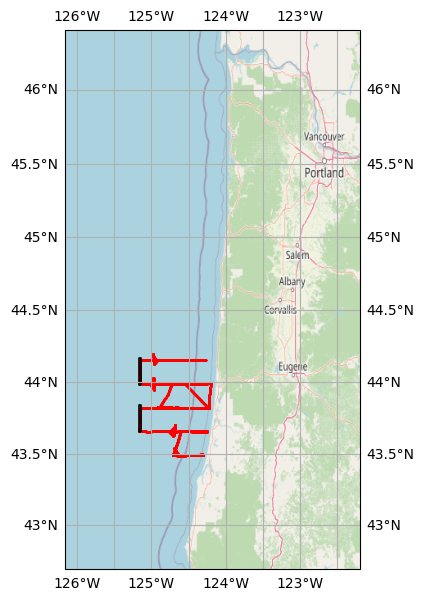

In [30]:
basemap = cimgt.OSM()

_, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": basemap.crs}
)
bnd = gps_gdf.geometry.bounds
ax.set_extent([bnd.minx.min() - 1, bnd.maxx.max() + 2, 
               bnd.miny.min() - 0.8, bnd.maxy.max() + 2.2])
ax.add_image(basemap, 7)
ax.gridlines(draw_labels=True, xformatter=LONGITUDE_FORMATTER, yformatter=LATITUDE_FORMATTER)

# GPS points
gps_gdf.plot(ax=ax, markersize=0.1, color='red', 
             transform=ccrs.PlateCarree())

# Bounding box for selected tracks
tracksouth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', 
                     transform=ccrs.PlateCarree())
tracknorth_bbox.plot(ax=ax, edgecolor="black", linewidth=1.2, facecolor='none', 
                     transform=ccrs.PlateCarree())

In [89]:
ds_freq_diff_NASC = ep.commongrid.compute_NASC(
    ds_freq_diff_MVBS.sel(depth=slice(0, 250)),
    range_bin="250m",
    dist_bin="2nmi"
)

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 11.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 11.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [94]:
ds_freq_diff_NASC["NASC"].isel(channel=0).data.compute()[0:10]

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 11.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


array([[5.14185645e+02],
       [2.85184368e+02],
       [1.72563933e+03],
       [2.18125316e+03],
       [3.10732310e+03],
       [1.01610949e+06],
       [5.74566193e+02],
       [2.12436271e+03],
       [1.04596262e+03],
       [1.29918533e+02]])

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 11.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


KeyError: 'Cannot create a colorbar when hue is None.'

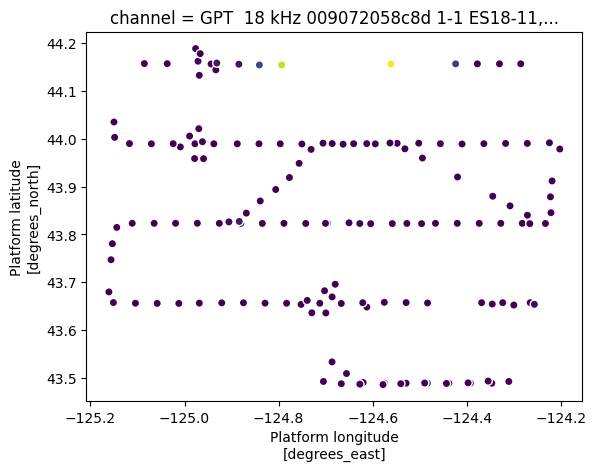

In [98]:
ds_freq_diff_NASC.isel(channel=0).plot.scatter(
    x="longitude",
    y="latitude",
    c=ds_freq_diff_NASC["NASC"].isel(channel=0),
    vmin=0,
    vmax=10,
    add_colorbar=True
)

In [84]:
np.nanmedian(ds_freq_diff_NASC["NASC"].isel(channel=0, depth=0).data.compute())

/home/exouser/miniforge3/envs/echopype/lib/python3.9/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 11.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


384.48872876323435

In [22]:
tracksouth_gps_gdf = gpd.clip(gps_gdf, tracksouth_bbox)
ds_tracksouth_MVBS = ds_MVBS.sel(
    ping_time=slice(tracksouth_gps_gdf.index.min(), tracksouth_gps_gdf.index.max())
)
ds_tracksouth_freq_diff_MVBS = ds_freq_diff_MVBS.sel(
    ping_time=slice(tracksouth_gps_gdf.index.min(), tracksouth_gps_gdf.index.max())
)

tracknorth_gps_gdf = gpd.clip(gps_gdf, tracknorth_bbox)
ds_tracknorth_MVBS = ds_MVBS.sel(
    ping_time=slice(tracknorth_gps_gdf.index.min(), tracknorth_gps_gdf.index.max())
)
ds_tracknorth_freq_diff_MVBS = ds_freq_diff_MVBS.sel(
    ping_time=slice(tracknorth_gps_gdf.index.min(), tracknorth_gps_gdf.index.max())
)

In [25]:
def track_interval_str(trackdt):
    """ Create the timestamp interval title string for a plot column
    """
    track_interval_title_str = (
        f"{trackdt.index.min().strftime('%b-%d %H:%MZ')}"
        f" to {trackdt.index.max().strftime('%b-%d %H:%MZ')}"
    )
    return track_interval_title_str

def plot_echograms(ds, freq_len, column_idx):
    """Plot echograms of the 3 frequencies for xarray dataset ds,
       as a column of subplots"""
    for f in range(freq_len):
        ax = axes[f][column_idx]
        # Select Sv data by frequency using the frequency_nominal coordinate index "f",
        # then plot the echogram of the selected data
        ds.Sv.isel(channel=f).sel(depth=slice(50, 250)).plot(
            ax=ax, 
            x='ping_time',
            y='depth',
            yincrease=False,
            vmin=-80,
            vmax=-50,
        )
        if f < 2:
            ax.set_xlabel(None)

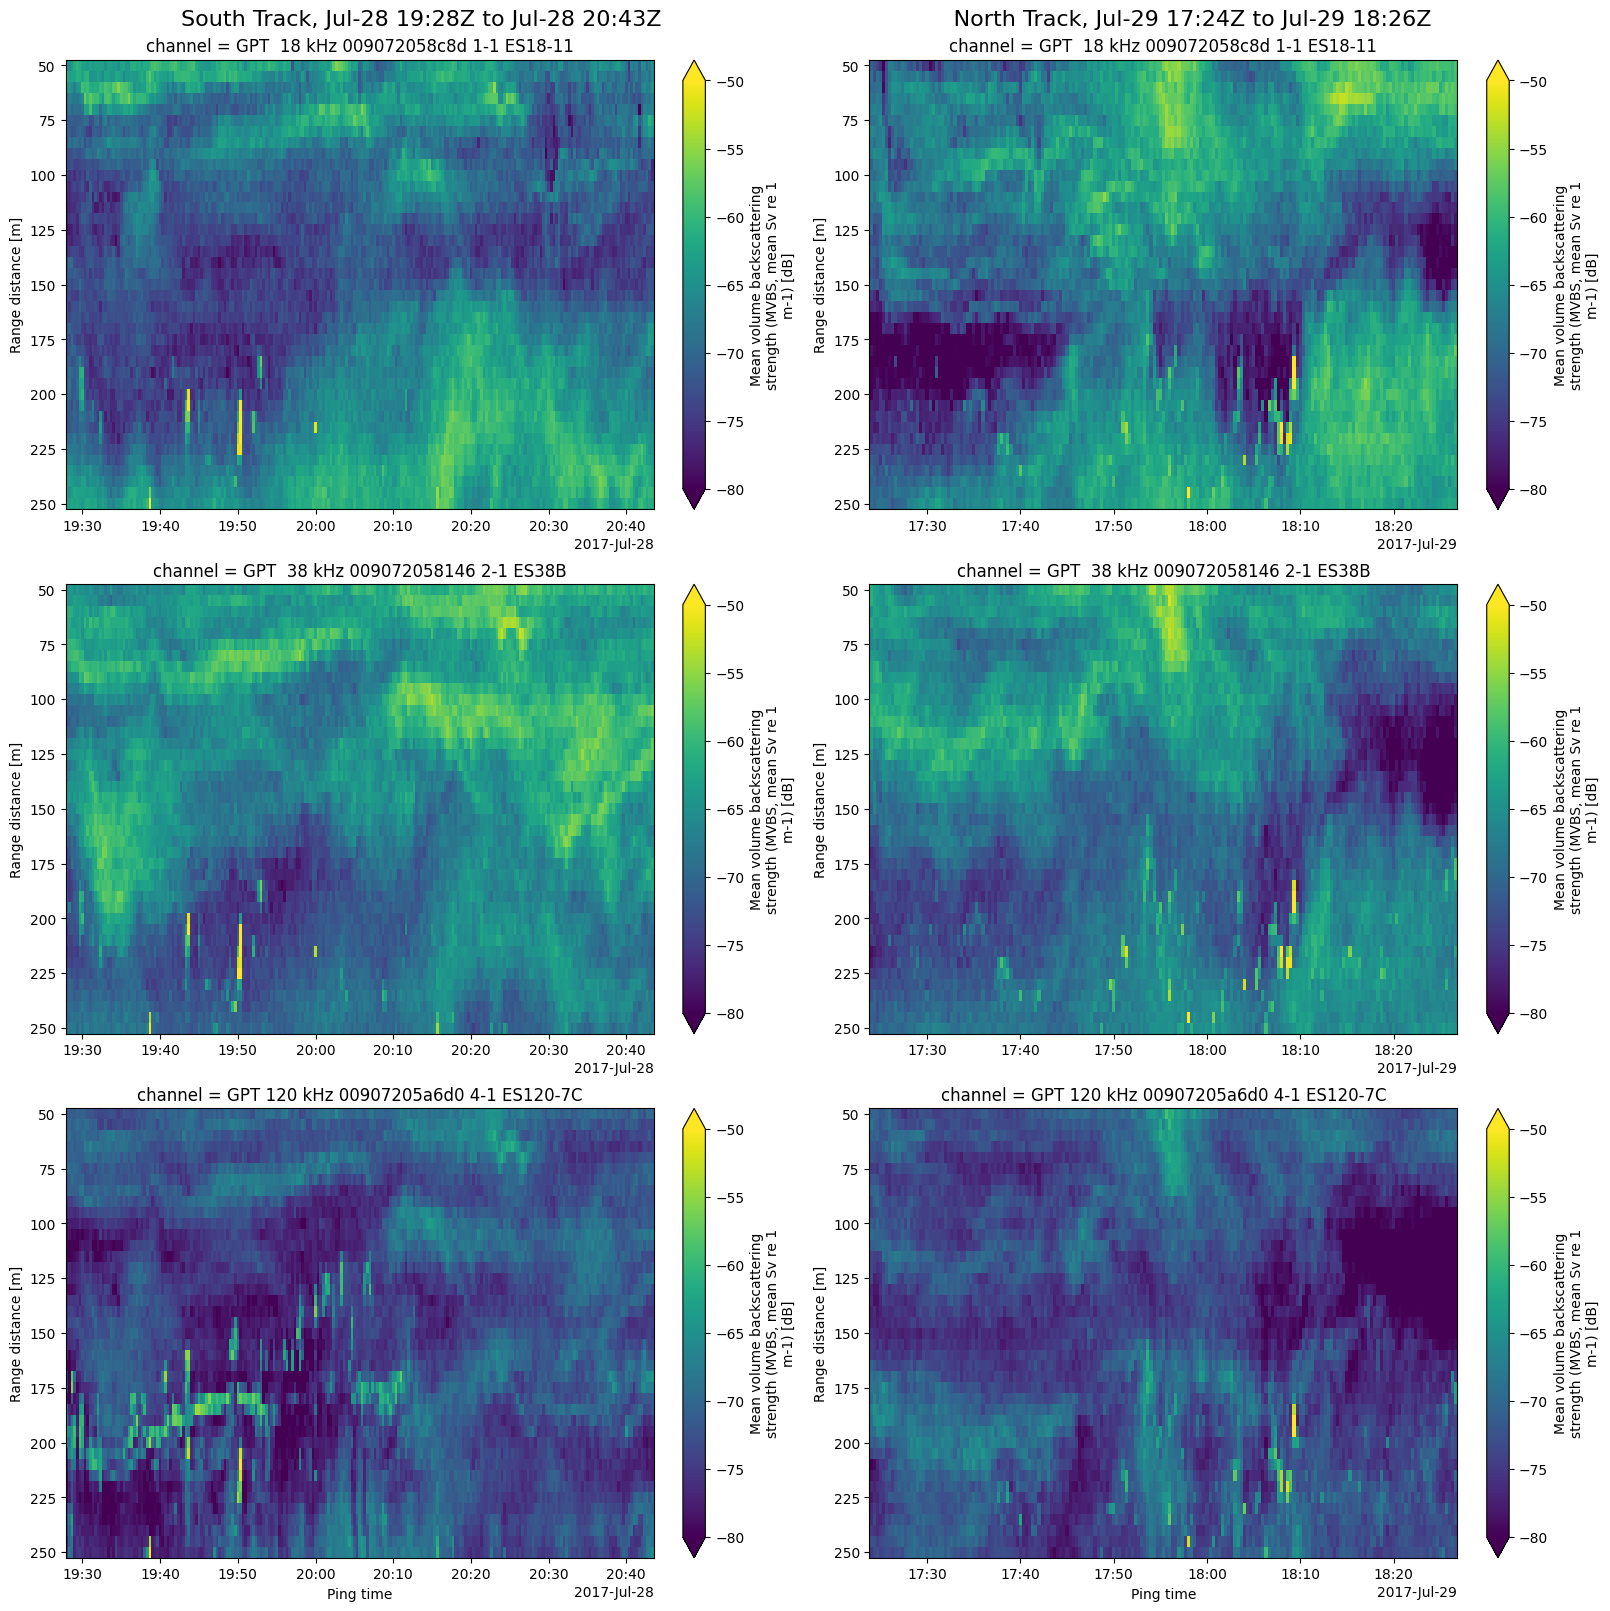

In [26]:
freq_len = len(ds_MVBS.channel)

fig, axes = plt.subplots(nrows=freq_len, ncols=2, constrained_layout=True, figsize=(16, 16))

fig.suptitle(
    (f"South Track, {track_interval_str(tracksouth_gps_gdf)}"
     "                                         "
     f"North Track, {track_interval_str(tracknorth_gps_gdf)}"),
    fontsize=16)

plot_echograms(ds_tracksouth_MVBS, freq_len, column_idx=0) # left column
plot_echograms(ds_tracknorth_MVBS, freq_len, column_idx=1) # right column

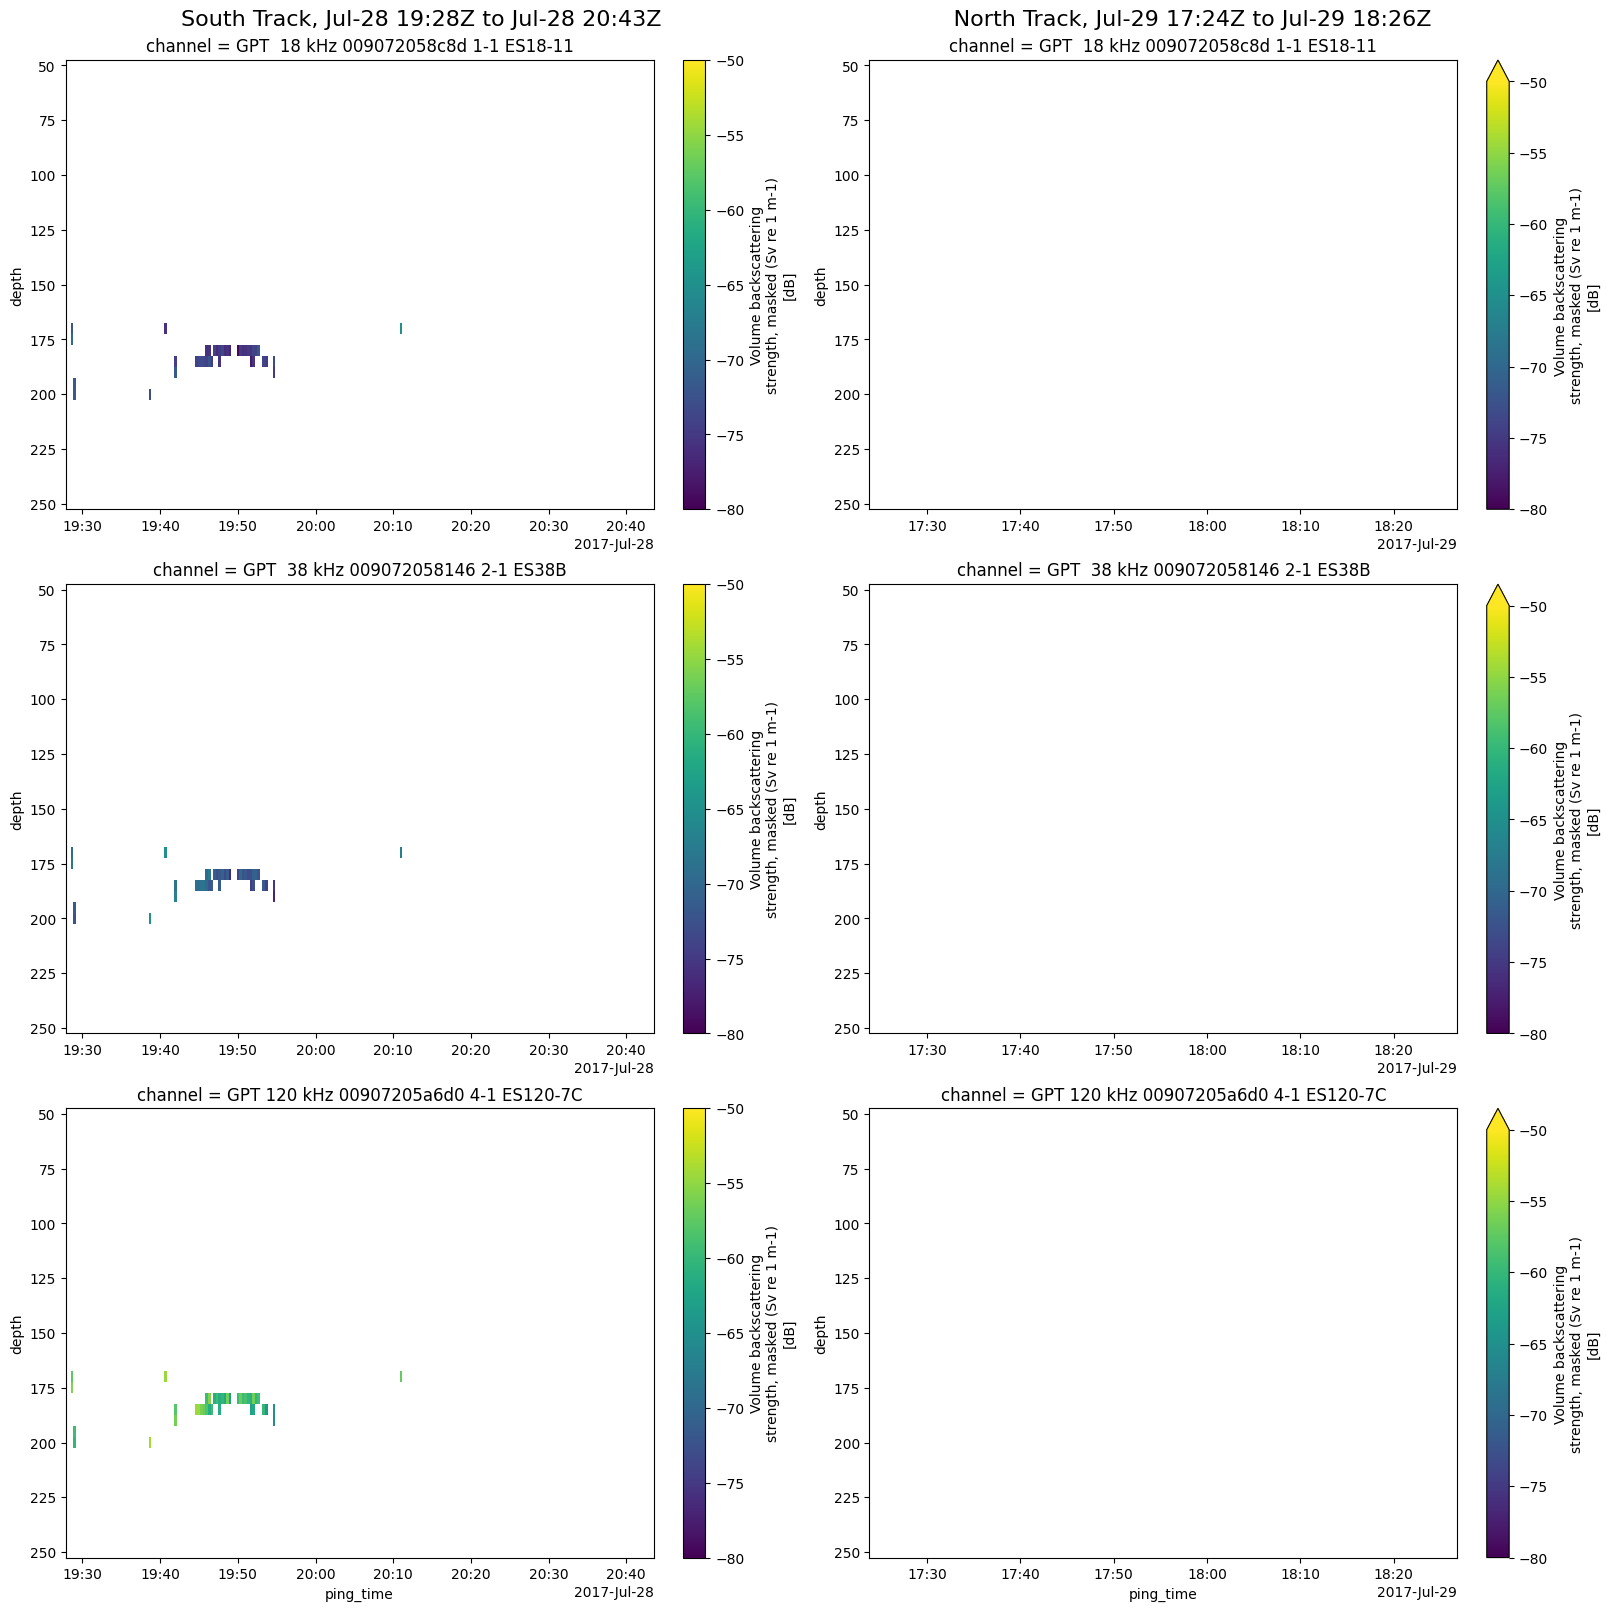

In [27]:
freq_len = len(ds_MVBS.channel)

fig, axes = plt.subplots(nrows=freq_len, ncols=2, constrained_layout=True, figsize=(16, 16))

fig.suptitle(
    (f"South Track, {track_interval_str(tracksouth_gps_gdf)}"
     "                                         "
     f"North Track, {track_interval_str(tracknorth_gps_gdf)}"),
    fontsize=16)

plot_echograms(ds_tracksouth_freq_diff_MVBS, freq_len, column_idx=0) # left column
plot_echograms(ds_tracknorth_freq_diff_MVBS, freq_len, column_idx=1) # right column